In [6]:
# Read the dataset description
import tensorflow as tf
tf.enable_eager_execution()
from pandas import read_csv

tagged = dict([(p,w) for _,p,w in read_csv('data/train.csv').to_records()])
submit = [p for _,p,_ in read_csv('data/sample_submission.csv').to_records()]
join   = list(tagged.keys()) + submit

In [7]:
len(tagged)

9850

In [9]:
import numpy as np

In [10]:
len(np.unique(tagged.values()))

4251

In [11]:
# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('data/train/train/' + p): return 'data/train/train/' + p
    if isfile('data/test/test/' + p): return 'data/test/test/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

/Users/filatovartm/python_env/sdc/lib/python2.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


(25460,
 [('11da3702.jpg', (1010, 435)),
  ('b493ea8a.jpg', (1050, 347)),
  ('3a070850.jpg', (812, 361)),
  ('878920aa.jpg', (1050, 525)),
  ('d8350a63.jpg', (1050, 700))])

In [13]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

img_shape = (384, 384, 1)
def build_model(lr, l2, activation='sigmoid'):

    ##############
    # BRANCH MODEL
    ##############
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=(384, 384, 1)) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)
    
    ############
    # HEAD MODEL
    ############
    mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])
    x1         = Lambda(lambda x : x[0]*x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : x[0] + x[1])([xa_inp, xb_inp])
    x3         = Lambda(lambda x : K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4         = Lambda(lambda x : K.square(x))(x3)
    x          = Concatenate()([x1, x2, x3, x4])
    x          = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x          = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x          = Flatten(name='flatten')(x)
    
    # Weighted sum implemented as a Dense layer.
    x          = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    x          = head_model([xa, xb])
    model      = Model([img_a, img_b], x)
    model.compile(tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model

model, branch_model, head_model = build_model(64e-5,0)
# head_model.summary()

In [14]:
model.load_weights('mpiotte-standard.model')

In [15]:
from matplotlib import pyplot as plt

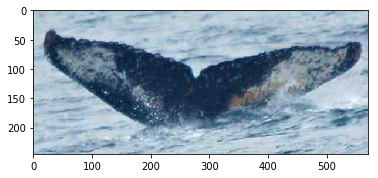

In [16]:
image = plt.imread('data/train/train/00acb5a9.jpg')
plt.imshow(image)

In [17]:
arr = np.array(image)

In [18]:
import skimage

In [20]:
resized = skimage.transform.resize(arr, (384, 384, 1))

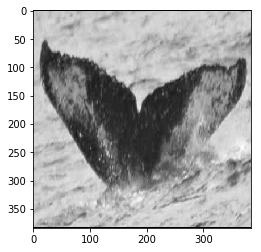

In [21]:
plt.imshow(resized[:, :, 0], cmap='gray')

In [22]:
features = branch_model(resized[None].astype(np.float32))

In [45]:
search = 'f56e9692.jpg'
same = tagged[search]
for key, value in tagged.items():
    if value == same and key != search:
        break

In [46]:
img_1 = plt.imread('data/train/train/{}'.format(search))
img_2 = plt.imread('data/train/train/{}'.format(key))

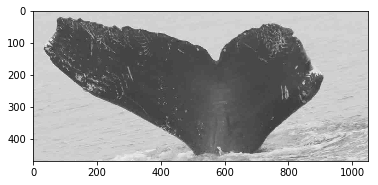

In [47]:
plt.imshow(img_1, cmap='gray')

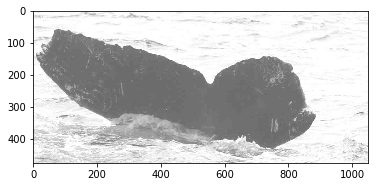

In [48]:
plt.imshow(img_2, cmap='gray')

In [49]:
resized_1 = skimage.transform.resize(img_1, (384, 384, 1))
resized_2 = skimage.transform.resize(img_2, (384, 384, 1))

In [50]:
model([
    resized_1[None].astype(np.float32),
    resized_2[None].astype(np.float32)])

<tf.Tensor: id=13848, shape=(1, 1), dtype=float32, numpy=array([[0.9975666]], dtype=float32)>

In [51]:
model([
    resized_1[None].astype(np.float32),
    resized[None].astype(np.float32)])

<tf.Tensor: id=15576, shape=(1, 1), dtype=float32, numpy=array([[0.9970668]], dtype=float32)>